In [1]:
import talib
from pandas import DataFrame, read_csv, concat
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU
from keras.callbacks import EarlyStopping,Callback
from keras import backend
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import numpy as np

In [2]:
data = read_csv('btc_hourly.csv', parse_dates = ['timestamp'], usecols = ['timestamp', 'c']).fillna(method='ffill')

In [4]:
sma = talib.SMA(data['c'], timeperiod = 5)
ema = talib.EMA(data['c'], timeperiod = 5)
macd = talib.MACD(data['c'])[0]
rsi = talib.RSI(data['c'])
mom = talib.MOM(data['c'], timeperiod = 9)
y = data['c'][33:]

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_mape', value=1, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)        
            
        if epoch>5:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            if current < self.value:                
                self.model.stop_training = True

In [8]:
features = DataFrame()
features['sma'] = sma[33:]
features['ema'] = ema[33:]
features['macd'] = macd[33:]
features['rsi'] = rsi[33:]
features['mom'] = mom[33:]
features['y'] = y

In [10]:
n = 1
split = int(0.7*(features.shape[0]-n))
train_raw = features[:split]
test_raw = features[split:]

In [12]:
train_scaler = MinMaxScaler(feature_range = (0,1))
train_scaler = train_scaler.fit(train_raw)
train = train_scaler.fit_transform(train_raw)

In [13]:
test_scaler = MinMaxScaler(feature_range = (0,1))
test_scaler = test_scaler.fit(test_raw)
test = test_scaler.fit_transform(test_raw)

In [14]:
train_series = series_to_supervised(train, n, n+1)
dropColumns = []
for i in range(train.shape[1]-1):
    dropColumns.append('var{}(t+{})'.format(i+1,n))
train_reframed = train_series.drop(columns=dropColumns)

test_series = series_to_supervised(test, n, n+1)
dropColumns = []
for i in range(test.shape[1]-1):
    dropColumns.append('var{}(t+{})'.format(i+1,n))
test_reframed = test_series.drop(columns=dropColumns)

In [15]:
train_X, test_X = train_reframed.values[:,:-1], test_reframed.values[:,:-1]
train_y, test_y = train_reframed.values[:,-1], test_reframed.values[:,-1]
#Reshaping input to be 3 dimensions (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [59]:
#BRL model
"""model = Sequential()
model.add(Bidirectional(GRU(32, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(LSTM(32, activation='tanh')) 
model.add(Dropout(0.1))
model.add(Dense(1))
backend.set_epsilon(1)
model.compile(optimizer='adam', loss='mse', metrics=['mape'])
callbacks = [EarlyStoppingByLossVal(monitor='val_mape', value=0.6, verbose=2)]"""

"model = Sequential()\nmodel.add(Bidirectional(GRU(32, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))))\nmodel.add(LSTM(32, activation='tanh')) \nmodel.add(Dropout(0.1))\nmodel.add(Dense(1))\nbackend.set_epsilon(1)\nmodel.compile(optimizer='adam', loss='mse', metrics=['mape'])\ncallbacks = [EarlyStoppingByLossVal(monitor='val_mape', value=0.6, verbose=2)]"

In [20]:
history = model.fit(train_X, train_y, epochs = 50, batch_size = train_X.shape[0]//40, validation_data=(test_X, test_y), verbose = 2, shuffle = False)#, callbacks=  callbacks)

Epoch 1/50
41/41 - 2s - loss: 0.0095 - mape: 4.5019 - val_loss: 0.0251 - val_mape: 12.8623
Epoch 2/50
41/41 - 0s - loss: 0.0129 - mape: 8.4870 - val_loss: 0.0218 - val_mape: 12.3775
Epoch 3/50
41/41 - 0s - loss: 0.0058 - mape: 5.3985 - val_loss: 0.0118 - val_mape: 9.1620
Epoch 4/50
41/41 - 0s - loss: 0.0030 - mape: 4.0838 - val_loss: 0.0052 - val_mape: 6.1297
Epoch 5/50
41/41 - 0s - loss: 0.0012 - mape: 2.7190 - val_loss: 0.0016 - val_mape: 3.4436
Epoch 6/50
41/41 - 0s - loss: 3.7150e-04 - mape: 1.6210 - val_loss: 3.0834e-04 - val_mape: 1.5687
Epoch 7/50
41/41 - 0s - loss: 1.1855e-04 - mape: 0.9484 - val_loss: 8.5131e-05 - val_mape: 0.7535
Epoch 8/50
41/41 - 0s - loss: 6.8892e-05 - mape: 0.7141 - val_loss: 6.2176e-05 - val_mape: 0.5884
Epoch 9/50
41/41 - 0s - loss: 6.4357e-05 - mape: 0.6802 - val_loss: 5.7688e-05 - val_mape: 0.5502
Epoch 10/50
41/41 - 0s - loss: 6.5496e-05 - mape: 0.6813 - val_loss: 5.4977e-05 - val_mape: 0.5250
Epoch 11/50
41/41 - 0s - loss: 6.5053e-05 - mape: 0.6724 

In [19]:
#Cocco et al. (2021) model
model = Sequential()
model.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
backend.set_epsilon(1)
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
callbacks = [EarlyStoppingByLossVal(monitor='val_mape', value=0.6, verbose=2)]

In [21]:
model_prediction = model.predict(test_X)
actualValues = np.array(y[-len(model_prediction):]).reshape(-1,1)
scalerCrypto = MinMaxScaler(feature_range = (0,1))
scalerCrypto = scalerCrypto.fit(actualValues)
scaledCrypto = scalerCrypto.fit_transform(actualValues)
model_prediction_unscale = scalerCrypto.inverse_transform(model_prediction)
predictedValues = np.reshape(model_prediction_unscale, model_prediction_unscale.shape[0])
actualValues = np.reshape(actualValues, actualValues.shape[0])

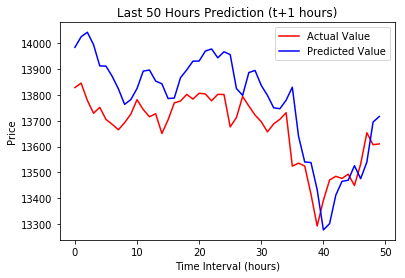

In [22]:
frm=-50
plt.plot(actualValues[frm:], color = 'red', label = 'Actual Value')
plt.plot(predictedValues[frm:], color = 'blue', label = 'Predicted Value') 
plt.title('Last {} Hours Prediction (t+{} hours)'.format(-frm, n))
plt.xlabel('Time Interval (hours)')
plt.ylabel('Price')
plt.legend()
plt.show()

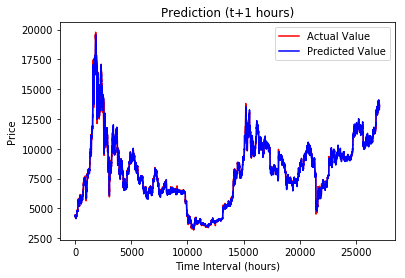

In [23]:
plt.plot(actualValues, color = 'red', label = 'Actual Value')
plt.plot(predictedValues, color = 'blue', label = 'Predicted Value')
plt.title('Prediction (t+{} hours)'.format(n))
plt.xlabel('Time Interval (hours)')
plt.ylabel('Price')
plt.legend()
plt.show()

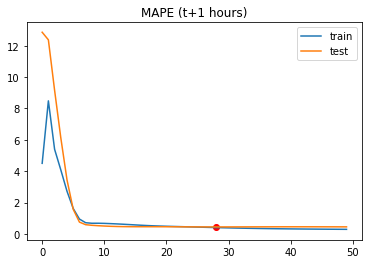

Best MAPE = 0.4464279115200043


In [24]:
plt.title('MAPE (t+{} hours)'.format(n))
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='test')
plt.scatter(np.argmin(history.history['val_mape']), min(history.history['val_mape']), color = 'r')
plt.legend()
plt.show()
print('Best MAPE = '+str(min((history.history['val_mape']))))

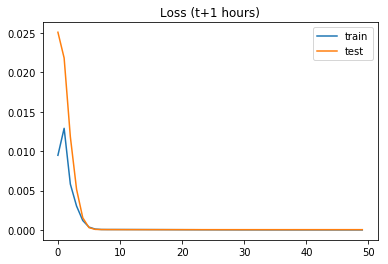

In [25]:
plt.title('Loss (t+{} hours)'.format(n))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [26]:
result_value=[]

for n_percent in range(3):
    actual_delta = []
    predicted_delta = []
    correct_long = 0
    incorrect_long = 0
    correct_short = 0
    incorrect_short = 0
    profit = []
    profit_agg = 0
    
    for i in range(2, len(actualValues) - 4):
        a_delta = (actualValues[i + 1] - actualValues[i]) / actualValues[i + 1]
        p_delta = (predictedValues[i + 1] - predictedValues[i]) / predictedValues[i + 1]

        if p_delta > 0 and a_delta > 0 and abs(p_delta)*100>n_percent:
            correct_long += 1
            profits = 10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits

        if p_delta > 0 > a_delta and abs(p_delta)*100>n_percent:
            incorrect_long += 1
            profits = -10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits

        if p_delta < 0 and a_delta < 0 and abs(p_delta)*100>n_percent:
            correct_short += 1
            profits = 10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits

        if p_delta < 0 < a_delta and abs(p_delta)*100>n_percent:
            incorrect_short += 1
            profits = -10000 * abs(a_delta)
            profit.append(profits)
            profit_agg += profits
            
    long_p=correct_long/(correct_long+incorrect_short)*100
    short_p=correct_short/(correct_short+incorrect_long)*100
    total_correct= (correct_long+correct_short)/(correct_long+incorrect_long+correct_short+incorrect_short)*100
    print('Analyzer 2 - Percent: ',n_percent)
    print("------------")
    print('LONG VALUES')
    print('correct_long', correct_long)
    print('incorrect_short', incorrect_short)
    print('correct_long_percentage', round(long_p,2))
    print('')
    print('SHORT VALUES')
    print('correct_short', correct_short)
    print('incorrect_long', incorrect_long)
    print('correct_short_percentage', round(short_p,2))
    print('')
    print('TOTAL')
    print('total_correct',correct_short+correct_long)
    print('total_incorrect',incorrect_long+incorrect_short )
    print('correct_total_percentage', round(total_correct,2))
    print('profit_tracker', round(profit_agg,2))
    print()
    print('########################################################')
    print()
        
    st='LONG VALUES\n\ncorrect_long: {}\nincorrect_short: {}\ncorrect_long_percentage: {}\n\nSHORT VALUES\n\ncorrect_short: {}\nincorrect_long: {}\ncorrect_short_percentage: {}\n\nTOTAL\n\ntotal_correct: {}\ntotal_incorrect: {}\ncorrect_total_percentage: {}\nprofit_tracker: {}'.format(correct_long,incorrect_short,long_p,correct_short,incorrect_long,short_p,correct_short+correct_long,incorrect_long+incorrect_short,total_correct,profit_agg)
    result_value.append(st)

Analyzer 2 - Percent:  0
------------
LONG VALUES
correct_long 6880
incorrect_short 6962
correct_long_percentage 49.7

SHORT VALUES
correct_short 5893
incorrect_long 7255
correct_short_percentage 44.82

TOTAL
total_correct 12773
total_incorrect 14217
correct_total_percentage 47.32
profit_tracker 13070.84

########################################################

Analyzer 2 - Percent:  1
------------
LONG VALUES
correct_long 390
incorrect_short 528
correct_long_percentage 42.48

SHORT VALUES
correct_short 492
incorrect_long 398
correct_short_percentage 55.28

TOTAL
total_correct 882
total_incorrect 926
correct_total_percentage 48.78
profit_tracker -8395.03

########################################################

Analyzer 2 - Percent:  2
------------
LONG VALUES
correct_long 52
incorrect_short 91
correct_long_percentage 36.36

SHORT VALUES
correct_short 79
incorrect_long 54
correct_short_percentage 59.4

TOTAL
total_correct 131
total_incorrect 145
correct_total_percentage 47.46
profit_